## Imports

In [2]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [4]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.6002, 0.4961, 0.3605], std=[0.2681, 0.2808, 0.2984]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [5]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Compute Mean and Standard Deviation for each R/G/B channel

In [ ]:
num_examples = 0
means = torch.zeros(3)
means_sq = torch.zeros(3)
for (x,y) in train_dataloader:
    batch_size = x.shape[0]
    num_examples += batch_size
    mean_i = x.mean(axis=(0,2,3))
    mean_sq_i = (x ** 2).mean(axis=(0,2,3))
    means += batch_size * mean_i
    means_sq += batch_size * mean_sq_i

means = means / num_examples
means_sq = means_sq / num_examples
stds = torch.sqrt(means_sq - means**2)
print("Computed Statistics...")
print("Computed Mean R/G/B: ", means)
print("Computed Standard Deviation R/G/B: ", stds)
print("")

## Creating ResNext model

In [9]:
model = models.resnext50_32x4d(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
model.fc = nn.Linear(2048, 172)
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Training the model

In [11]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        for x, y in batches:
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x), gpu(y)                
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [12]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=5)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 1 Training Loss: 0.0027 Got 62391 / 66071 correct. Acc: 94.43%
Epoch: 1 Validation Loss: 0.0147 Got 8635 / 11016 correct 78.39%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 2 Training Loss: 0.0027 Got 62325 / 66071 correct. Acc: 94.33%
Epoch: 2 Validation Loss: 0.0148 Got 8603 / 11016 correct 78.10%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 3 Training Loss: 0.0027 Got 62308 / 66071 correct. Acc: 94.30%
Epoch: 3 Validation Loss: 0.0147 Got 8615 / 11016 correct 78.20%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 90

In [14]:
# Save the model.
PATH = "../saved_models/food/resnext/resnext.dat"
torch.save(model, PATH)
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, '../saved_models/food/resnext/resnext-history.pt')

## Evaluation

In [7]:
# Load the model.
PATH = "../saved_models/food/resnext/resnext.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/resnext/resnext-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

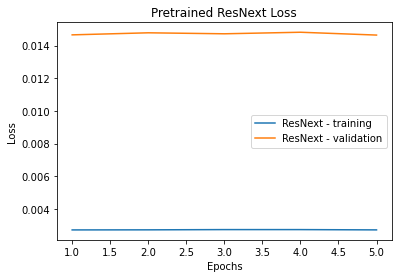

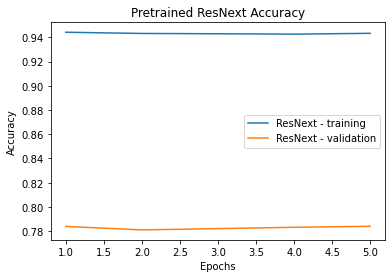

In [8]:
# Loss and Accuracy Curves

# TODO: Retrain this model (this model is missing the data for the first five epochs of training).
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('ResNext', LOSS, ACC, LOSS_V, ACC_V)

In [16]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 78.35 %


In [17]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 94.54 %


In [18]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [19]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[254   1   0 ...   0   1   0]
 [  0 240   0 ...   0   0   0]
 [  0   0  51 ...   0   0   0]
 ...
 [  0   0   0 ...  89   2   0]
 [  0   0   0 ...   0  66   0]
 [  0   0   0 ...   0   0 154]]
254 307


<AxesSubplot:>

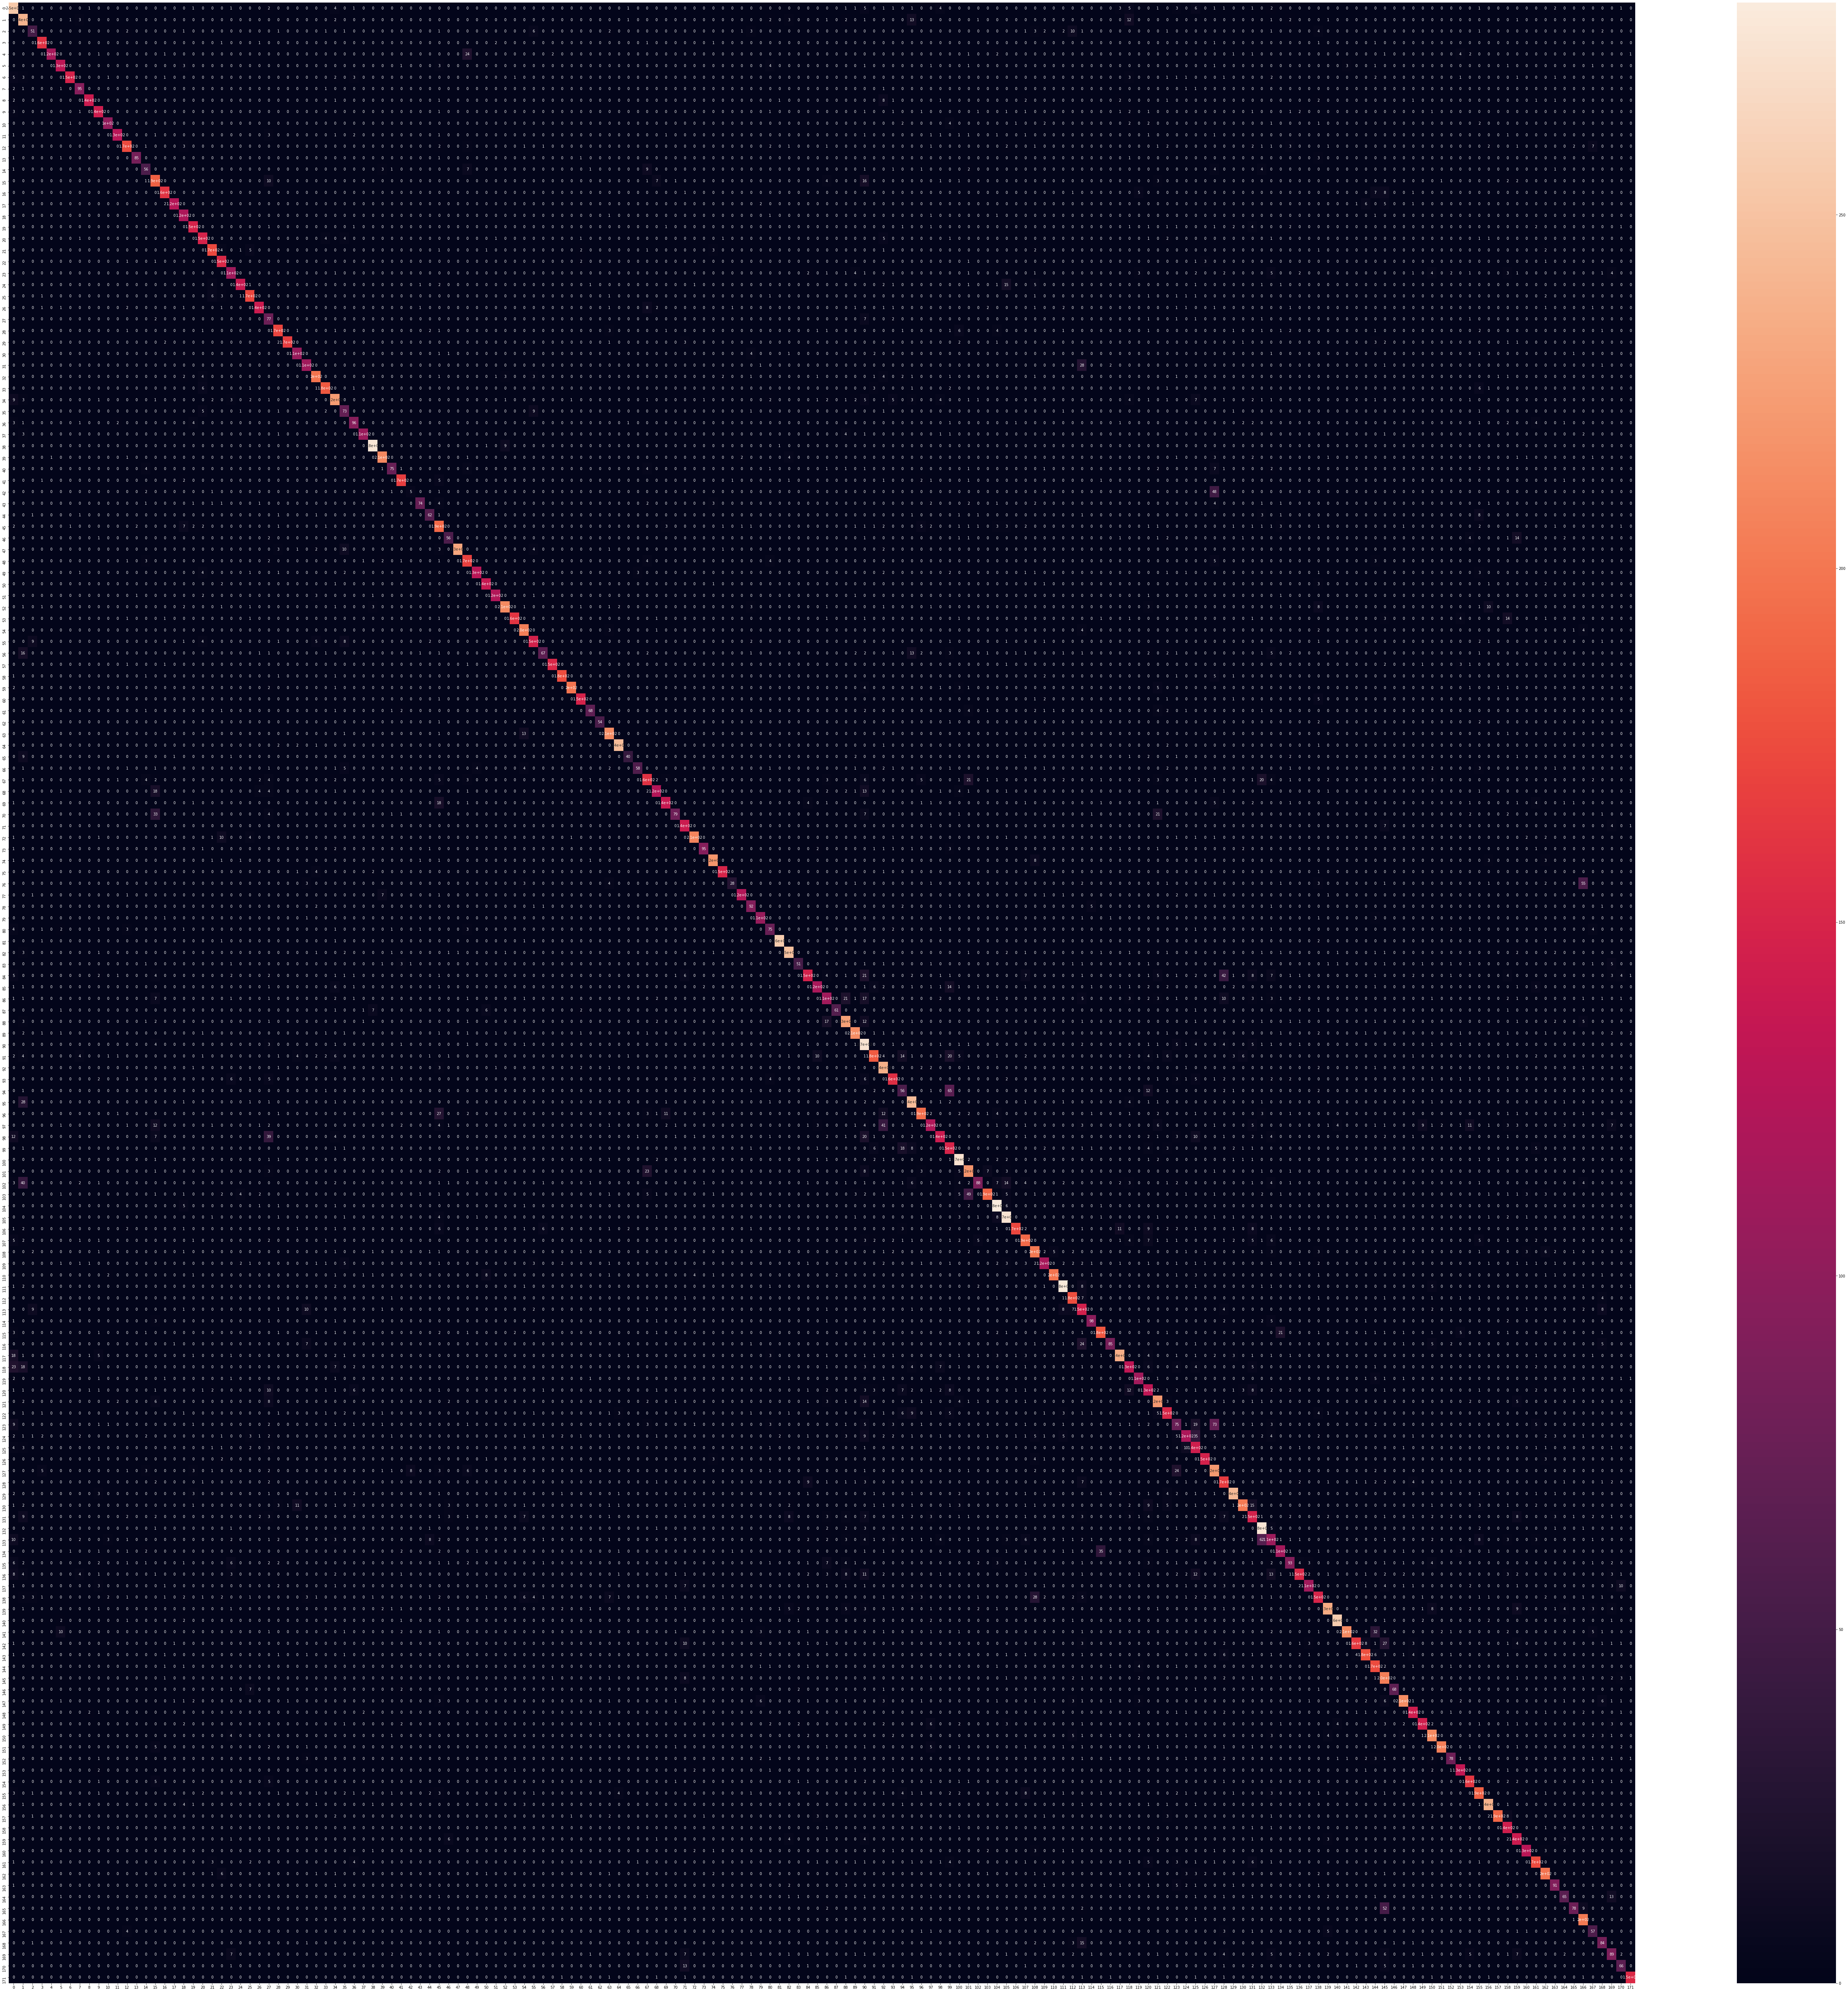

In [21]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

In [22]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=food_names))


Accuracy: 0.78

Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.80
Macro Recall: 0.78
Macro F1-score: 0.78

Weighted Precision: 0.80
Weighted Recall: 0.78
Weighted F1-score: 0.78

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.60      0.83      0.70       307
                          Sautéed Spicy Pork       0.57      0.84      0.68       287
             Cripsy sweet & sour pork slices       0.64      0.52      0.57        98
               Steamed pork with rice powder       0.91      0.95      0.93       168
                  Pork with salted vegetable       0.99      0.74      0.85       156
                   Shredded Pork with pepper       0.83      0.86      0.85       152
                     Yu-Shiang Shredded Pork       0.96      0.83      0.89       178
  Sautéed Sliced Pork, Eggs and Black Fungus       0.80      0.92      0.

In [23]:
print(len(y_test))

33154


In [24]:
# Class 0 Statistics

TP = 0
FP = 0
FN = 0
for pred,label in zip(y_pred, y_test):
    if pred == 0 and label == 0:
        TP += 1
    if pred == 0 and label != 0:
        FP += 1
    if pred != 0 and label == 0:
        FN += 1
print("Class 0 ({}) Statistics".format(food_names[0]))
print("True Positives: {}".format(TP))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))
print("Precision: {}".format(TP / (TP + FP)))
print("Recall: {}".format(TP / (TP + FN)))

Class 0 (Braised Pork) Statistics
True Positives: 254
False Positives: 169
False Negatives: 53
Precision: 0.6004728132387707
Recall: 0.8273615635179153
